In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

import dataset
assert tf.config.list_physical_devices('GPU')

MAXLEN = 60
BATCH_SIZE = 32

Using TensorFlow backend.


In [7]:
EMBED_DIM = 512
UNITS = 256

NIQQUD_SIZE = len(dataset.niqqud_table)
DAGESH_SIZE = len(dataset.dagesh_table)
LETTERS_SIZE = len(dataset.letters_table)

common_input = tf.keras.Input(batch_shape=(None, MAXLEN), batch_size=BATCH_SIZE)
common = layers.Embedding(LETTERS_SIZE, EMBED_DIM, mask_zero=True)(common_input)
common = layers.Bidirectional(layers.LSTM(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum')(common)

common = layers.add([common, layers.Bidirectional(layers.LSTM(UNITS, return_sequences=True, dropout=0.1), merge_mode='sum')(common)])

niqqud = layers.Softmax(name='N')(layers.Dense(NIQQUD_SIZE)(common))
dagesh = layers.Softmax(name='D')(layers.Dense(DAGESH_SIZE)(common))

model = tf.keras.Model(inputs=[common_input], outputs=[niqqud, dagesh])

tf.keras.utils.plot_model(model, to_file='model.png')

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

def fit(data, learning_rates):
    return model.fit(data.normalized_texts, [data.niqqud_texts, data.dagesh_texts],
          batch_size=BATCH_SIZE,
          epochs=len(learning_rates),
          validation_data=(data.normalized_validation, [data.niqqud_validation,  data.dagesh_validation]),
          callbacks=[
              tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: learning_rates[epoch], verbose=0),
              # tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints/ckpt_{epoch}', save_weights_only=True),
          ]
    )

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 512)      24576       input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 60, 256)      1574912     embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 60, 256)      1050624     bidirectional_2[0][0]            
______

In [8]:
def load_data():
    rabanit = ['birkat_hamazon.txt', 'hakdama_leorot.txt', 'hartzaat_harav.txt', 'orhot_hayim.txt', 'rambam_mamre.txt', 'short_table.txt', 'tomer_dvora.txt', 'breslev.txt']
    modern = ['atar_hashabat.txt', 'kakun.txt', 'sisters.txt', 'treasure_island.txt', 'ali_baba.txt', 'people.txt', 'ricky.txt', 'imagination.txt', 'adamtsair.txt', 'katarsis.txt']
    filenames = ['texts/' + f for f in rabanit + modern]
    return dataset.load_file(filenames, BATCH_SIZE, 0.01, maxlen=MAXLEN, shuffle=True)

data = load_data()

In [9]:
history = fit(data, [2e-3, 2e-4]) #, 1e-4, 3e-6])

Train on 100298 samples, validate on 1014 samples
Epoch 1/2
100298/100298 [==============================] - 127s 1ms/sample - loss: 0.2670 - N_loss: 0.2109 - D_loss: 0.0561 - N_accuracy: 0.9279 - D_accuracy: 0.9788 - val_loss: 0.1394 - val_N_loss: 0.1056 - val_D_loss: 0.0337 - val_N_accuracy: 0.9642 - val_D_accuracy: 0.9872
Epoch 2/2
100298/100298 [==============================] - 120s 1ms/sample - loss: 0.1136 - N_loss: 0.0848 - D_loss: 0.0288 - N_accuracy: 0.9721 - D_accuracy: 0.9894 - val_loss: 0.1056 - val_N_loss: 0.0786 - val_D_loss: 0.0271 - val_N_accuracy: 0.9746 - val_D_accuracy: 0.9898


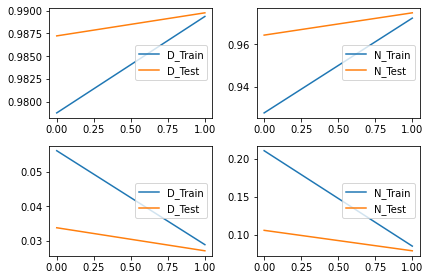

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2)

for n, v in enumerate(['accuracy', 'loss'], 0):
    for n1, t in enumerate(['D', 'N'], 0):
        p = ax[n][n1]
        p.plot(history.history[t + '_' + v][0:])
        p.plot(history.history['val_' + t + '_' +  v][0:])
        p.legend([t + '_Train', t + '_Test'], loc='center right')

plt.tight_layout()

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, '.')

In [11]:
def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.normalized_validation[s]
    prediction = model.predict(batch)
    [actual_niqqud, actual_dagesh] = [dataset.from_categorical(prediction[0]), dataset.from_categorical(prediction[1])]
    [expected_niqqud, expected_dagesh] = [data.niqqud_validation[s], data.dagesh_validation[s]]
    actual = data.merge(batch, ns=actual_niqqud, ds=actual_dagesh)
    expected = data.merge(batch, ns=expected_niqqud, ds=expected_dagesh)
    for i, (a, e) in enumerate(zip(actual, expected)):
        print('מצוי: ', a)
        print('רצוי: ', e)
        print()

print_predictions(1)

מצוי:  וְשֶיִּהְיֶה הַמְּהַלֵּךְ עַל גַּבֵּי הָאָרוֹן כַּנוֹגֵעַ בְּמֵּת אוֹ בַּקֶּבֶר. (ז) קוֹרָה שְהִיא
רצוי:  וְשֶיִּהְיֶה הַמְּהַלֵּךְ עַל גַּבֵּי הָאָרוֹן כְּנוֹגֵעַ בְּמֵת אוֹ בְּקֶבֶר. (ז) קוֹרָה שְהִיא

מצוי:  כָּךְ," אָמַר הָרוֹפֵא, "עוֹד נִרְאֶה." מִשֶּיָצָאנוּ אֶל הַסִפּוּן כְּבָר הִתְחִילוּ
רצוי:  כָּךְ," אָמַר הָרוֹפֵא, "עוֹד נִרְאֶה." מִשֶיָצָאנוּ אֶל הַסִפּוּן כְּבָר הִתְחִילוּ

מצוי:  אֵצֶל חָכָם וִיבַקֵּש עָלָיו רַחֲמִים שֶנֶּאֱמַר חֲמַת מֶלֶךְ מַלְאֲכֵי מָוֹת וְאִיש חָכָם
רצוי:  אֵצֶל חָכָם וִיבַקֵּש עָלָיו רַחֲמִים שֶנֶּאֱמַר חֲמַת מֶלֶךְ מַלְאֲכֵי מָוֶת וְאִיש חָכָם

מצוי:  וּמַיִם, כְּדֵי לִרְחֹץ פְּנֵי מְדּוּכָה. דְּבַש, כְּדֵי לִתֵּן עַל כָּל רֹאש הַכְּתִּית. דָּם,
רצוי:  וּמַיִם, כְּדֵי לִרְחֹץ פְּנֵי מְדוֹכָה. דְּבַש, כְּדֵי לִתֵּן עַל כָּל רֹאש הַכָּתִית. דָּם,

מצוי:  הַחֹם יָתֵר; וְיֵש מֵהֶם גּוּפִים שֶיִּהְיֶה בָּהֶם חֲזָקָה מִיְּסוֹד הָאָרֶץ כְּמוֹ
רצוי:  הַחֹם יָתֵר; וְיֵש מֵהֶם גּוּפִים שֶיִּהְיֶה בָּהֶם חָזְקָה מִיְּסוֹד הָאָרֶץ כְּמוֹ

מצוי:  עִמּוֹ" (

In [ ]:
print([ord(x) for x in ['־', '‒', '–', '—', '―', '−']
      ])

In [ ]:
print(ord('ׁ'))